# 02 - Feature Extraction

In this notebook, we'll learn how to extract meaningful features from video frames using pre-trained neural networks.

## Learning Objectives

By the end of this notebook, you will:
- Understand how pre-trained models work for feature extraction
- Extract features from video frames using different architectures
- Compare different feature extraction methods
- Understand temporal pooling strategies
- **Complete 6 hands-on exercises** requiring deep understanding

## Key Concepts

**Feature Extraction**: Converting raw video frames into numerical representations that capture important visual information.

**Pre-trained Models**: Neural networks trained on large datasets (like ImageNet) that can extract useful features from images.

**Temporal Pooling**: Combining features from multiple frames to create a single video representation.

## Important Note

This notebook contains **interactive exercises** that require you to understand the underlying concepts. Each exercise builds on previous knowledge and requires critical thinking about feature extraction strategies.

In [1]:
# Import required libraries
import sys
import os
from pathlib import Path

# Add the project root to the path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Import our utilities
from utils.video_utils import load_video, create_frame_transforms, frames_to_tensor
from utils.model_utils import VideoFeatureExtractor, get_model_summary
from utils.data_utils import VideoDataset

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

/Users/adityacode/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!
PyTorch version: 2.2.2
CUDA available: False


## 1. Understanding Pre-trained Models

Let's start by exploring what pre-trained models are available and how they work.

In [2]:
# List available pre-trained models
print("Available pre-trained models in torchvision:")
print("\nResNet models:")
print("- resnet18")
print("- resnet34")
print("- resnet50")
print("- resnet101")
print("- resnet152")

print("\nOther models:")
print("- vgg16")
print("- alexnet")
print("- squeezenet")
print("- densenet121")

# Let's examine the structure of ResNet50
print("\n" + "="*50)
print("RESNET50 ARCHITECTURE")
print("="*50)

resnet50 = models.resnet50(pretrained=True)
print(f"ResNet50 has {len(list(resnet50.children()))} main layers:")

for i, layer in enumerate(resnet50.children()):
    print(f"Layer {i}: {type(layer).__name__}")
    if hasattr(layer, 'out_channels'):
        print(f"  Output channels: {layer.out_channels}")
    elif hasattr(layer, 'out_features'):
        print(f"  Output features: {layer.out_features}")

Available pre-trained models in torchvision:

ResNet models:
- resnet18
- resnet34
- resnet50
- resnet101
- resnet152

Other models:
- vgg16
- alexnet
- squeezenet
- densenet121

RESNET50 ARCHITECTURE


/Users/adityacode/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adityacode/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/adityacode/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 46.3MB/s]

ResNet50 has 10 main layers:
Layer 0: Conv2d
  Output channels: 64
Layer 1: BatchNorm2d
Layer 2: ReLU
Layer 3: MaxPool2d
Layer 4: Sequential
Layer 5: Sequential
Layer 6: Sequential
Layer 7: Sequential
Layer 8: AdaptiveAvgPool2d
Layer 9: Linear
  Output features: 1000


## 🎯 EXERCISE 1: Model Architecture Analysis

**Task**: Analyze different pre-trained models and understand their characteristics.

**Requirements**:
1. Load 3 different pre-trained models (ResNet18, VGG16, DenseNet121)
2. Compare their parameter counts and model sizes
3. Analyze the output feature dimensions of each model
4. Create a bar chart comparing model complexities
5. Determine which model would be best for real-time processing

**Your code here**:

In [ ]:
# TODO: Write your model architecture analysis code

# 1. Load 3 different models
# Your code here...

# 2. Compare parameter counts
# Your code here...

# 3. Analyze output dimensions
# Your code here...

# 4. Create comparison chart
# Your code here...

# 5. Determine best for real-time processing
# Your code here...

## 2. Loading and Preparing Video Data

Let's load some video data to work with.

Loading video: sample_video_0044.mp4


[ WARN:0@43.982] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@43.982] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin0 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@43.983] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@43.983] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/s

Loaded 10 frames with shape: (10, 240, 320, 3)


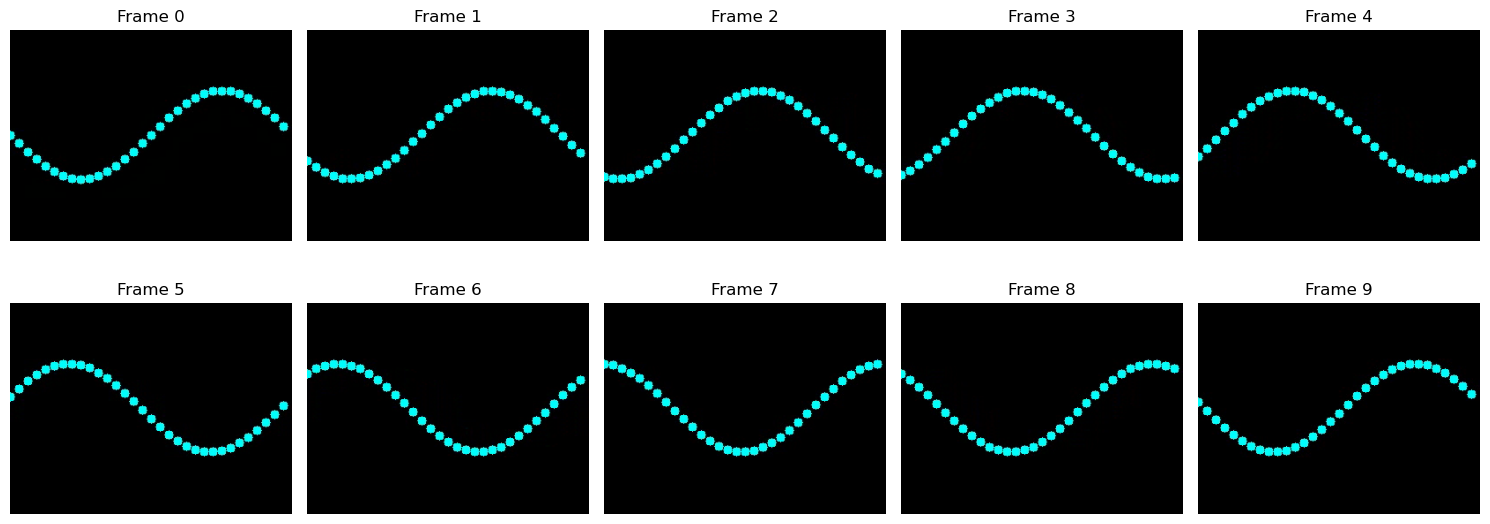

In [3]:
# Define data paths
data_dir = project_root / "data" / "videos"
metadata_file = data_dir / "sample_metadata.csv"

# Load a sample video
video_files = list(data_dir.glob("*.mp4"))
if video_files:
    sample_video = str(video_files[0])
    print(f"Loading video: {os.path.basename(sample_video)}")
    
    # Load video frames
    frames = load_video(sample_video, max_frames=10)  # Use fewer frames for demonstration
    print(f"Loaded {len(frames)} frames with shape: {frames.shape}")
    
    # Show first few frames
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i in range(min(10, len(frames))):
        axes[i].imshow(frames[i])
        axes[i].set_title(f'Frame {i}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No video files found. Please run the data download script first.")

## 3. Manual Feature Extraction

Let's manually extract features from a single frame to understand the process.

Single frame shape: (240, 320, 3)
Transformed frame tensor shape: torch.Size([3, 224, 224])
Batch tensor shape: torch.Size([1, 3, 224, 224])
Extracted features shape: torch.Size([1, 2048, 1, 1])
Feature vector length: 2048
Flattened features shape: torch.Size([2048])

Feature statistics:
Mean: 0.4644
Std: 0.1014
Min: 0.1613
Max: 1.2010


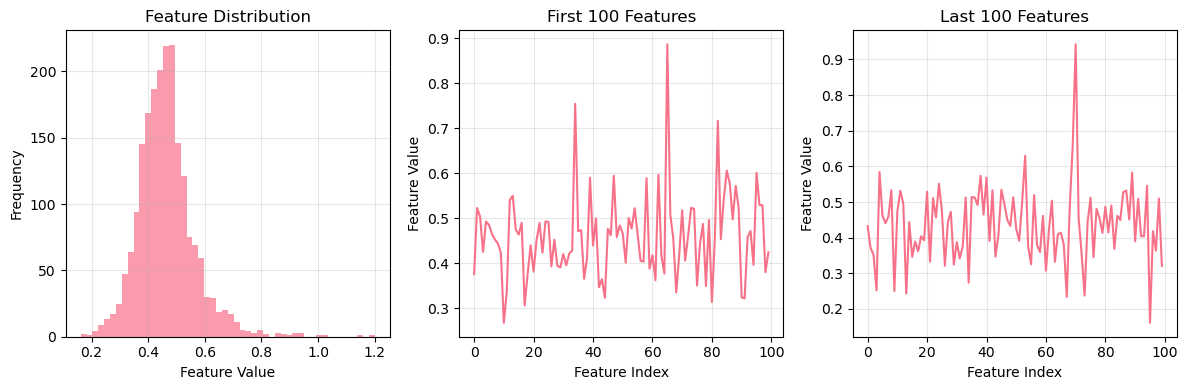

In [4]:
# Manual feature extraction from a single frame
if 'frames' in locals():
    # Take the first frame
    single_frame = frames[0]
    print(f"Single frame shape: {single_frame.shape}")
    
    # Create transforms for the frame
    transform = create_frame_transforms(image_size=224, is_training=False)
    
    # Transform the frame
    frame_tensor = transform(single_frame)
    print(f"Transformed frame tensor shape: {frame_tensor.shape}")
    
    # Add batch dimension
    frame_batch = frame_tensor.unsqueeze(0)
    print(f"Batch tensor shape: {frame_batch.shape}")
    
    # Extract features using ResNet50 (remove the final classification layer)
    resnet50_features = models.resnet50(pretrained=True)
    # Remove the final classification layer
    feature_extractor = nn.Sequential(*list(resnet50_features.children())[:-1])
    
    # Extract features
    with torch.no_grad():
        features = feature_extractor(frame_batch)
        
    print(f"Extracted features shape: {features.shape}")
    print(f"Feature vector length: {features.numel()}")
    
    # Flatten the features
    features_flat = features.squeeze()
    print(f"Flattened features shape: {features_flat.shape}")
    
    # Show feature statistics
    print(f"\nFeature statistics:")
    print(f"Mean: {features_flat.mean():.4f}")
    print(f"Std: {features_flat.std():.4f}")
    print(f"Min: {features_flat.min():.4f}")
    print(f"Max: {features_flat.max():.4f}")
    
    # Visualize feature distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.hist(features_flat.numpy(), bins=50, alpha=0.7)
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')
    plt.title('Feature Distribution')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(features_flat.numpy()[:100])  # Show first 100 features
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.title('First 100 Features')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.plot(features_flat.numpy()[-100:])  # Show last 100 features
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.title('Last 100 Features')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 🎯 EXERCISE 2: Feature Analysis and Comparison

**Task**: Compare features extracted from different frames and models.

**Requirements**:
1. Extract features from 3 different frames of the same video
2. Calculate the cosine similarity between these feature vectors
3. Extract features using 2 different models (ResNet18 and VGG16)
4. Compare the feature distributions between models
5. Create a heatmap showing feature similarities across frames

**Your code here**:

In [ ]:
# TODO: Write your feature analysis and comparison code

# 1. Extract features from 3 different frames
# Your code here...

# 2. Calculate cosine similarity
# Your code here...

# 3. Extract features with different models
# Your code here...

# 4. Compare feature distributions
# Your code here...

# 5. Create similarity heatmap
# Your code here...

## 4. Using Our VideoFeatureExtractor Class

Now let's use our custom VideoFeatureExtractor class to extract features from multiple frames.

In [7]:
feature_extractor = VideoFeatureExtractor(
    backbone='resnet50',  # Correct parameter name (instead of model_name)
    feature_dim=2048,     # Specify the feature dimension
    num_frames=30,        # Specify number of frames
    pooling_method='mean' # Correct parameter name (instead of pooling_strategy)
)

print("Feature extractor created successfully!")
print(f"Backbone: {feature_extractor.backbone}")
print(f"Output dimension: {feature_extractor.feature_dim}")
print(f"Pooling method: {feature_extractor.pooling_method}")

TypeError: VideoFeatureExtractor.__init__() got an unexpected keyword argument 'image_size'

In [6]:
# Extract features from video frames
if 'frames' in locals():
    print(f"Extracting features from {len(frames)} frames...")
    
    # Extract features
    video_features = feature_extractor.extract_features(frames)
    
    print(f"Video features shape: {video_features.shape}")
    print(f"Feature vector length: {video_features.numel()}")
    
    # Show feature statistics
    print(f"\nFeature statistics:")
    print(f"Mean: {video_features.mean():.4f}")
    print(f"Std: {video_features.std():.4f}")
    print(f"Min: {video_features.min():.4f}")
    print(f"Max: {video_features.max():.4f}")
    
    # Visualize feature vector
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(video_features.numpy(), bins=50, alpha=0.7)
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')
    plt.title('Video Feature Distribution')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(video_features.numpy())
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.title('Video Feature Vector')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Extracting features from 10 frames...


AttributeError: 'Sequential' object has no attribute 'extract_features'

## 🎯 EXERCISE 3: Temporal Pooling Strategies

**Task**: Implement and compare different temporal pooling strategies.

**Requirements**:
1. Implement 3 different pooling strategies: mean, max, and attention-based
2. Extract frame-level features from a video
3. Apply each pooling strategy to get video-level features
4. Compare the resulting feature vectors
5. Analyze which pooling strategy preserves the most information

**Your code here**:

In [ ]:
# TODO: Write your temporal pooling strategies code

# 1. Implement pooling strategies
# Your code here...

# 2. Extract frame-level features
# Your code here...

# 3. Apply each pooling strategy
# Your code here...

# 4. Compare feature vectors
# Your code here...

# 5. Analyze information preservation
# Your code here...

## 5. Batch Processing Multiple Videos

Let's extract features from multiple videos efficiently.

In [ ]:
# Load multiple videos
if video_files:
    print(f"Processing {min(5, len(video_files))} videos...")
    
    all_video_features = []
    video_names = []
    
    for i, video_file in enumerate(video_files[:5]):
        try:
            print(f"Processing video {i+1}: {video_file.name}")
            
            # Load frames
            frames = load_video(str(video_file), max_frames=10)
            
            # Extract features
            features = feature_extractor.extract_features(frames)
            
            all_video_features.append(features)
            video_names.append(video_file.name)
            
        except Exception as e:
            print(f"Error processing {video_file.name}: {e}")
    
    if all_video_features:
        # Stack all features
        features_matrix = torch.stack(all_video_features)
        print(f"\nFeatures matrix shape: {features_matrix.shape}")
        
        # Calculate pairwise similarities
        similarities = torch.mm(features_matrix, features_matrix.t())
        
        # Normalize similarities
        norms = torch.norm(features_matrix, dim=1, keepdim=True)
        normalized_similarities = similarities / (norms * norms.t())
        
        # Visualize similarity matrix
        plt.figure(figsize=(10, 8))
        plt.imshow(normalized_similarities.numpy(), cmap='viridis')
        plt.colorbar(label='Cosine Similarity')
        plt.title('Video Similarity Matrix')
        plt.xlabel('Video Index')
        plt.ylabel('Video Index')
        
        # Add video names as tick labels
        plt.xticks(range(len(video_names)), [name[:15] + '...' for name in video_names], rotation=45)
        plt.yticks(range(len(video_names)), [name[:15] + '...' for name in video_names])
        
        plt.tight_layout()
        plt.show()

## 🎯 EXERCISE 4: Feature Similarity Analysis

**Task**: Analyze feature similarities and identify patterns.

**Requirements**:
1. Load metadata to get video labels
2. Calculate average similarity within same-label videos vs different-label videos
3. Create a confusion matrix showing similarity patterns
4. Identify which videos are most similar/different
5. Suggest feature extraction improvements based on your analysis

**Your code here**:

In [ ]:
# TODO: Write your feature similarity analysis code

# 1. Load metadata and get labels
# Your code here...

# 2. Calculate average similarities
# Your code here...

# 3. Create confusion matrix
# Your code here...

# 4. Identify most similar/different videos
# Your code here...

# 5. Suggest improvements
# Your code here...

## 6. Feature Dimensionality and Compression

Let's explore techniques for reducing feature dimensionality.

In [ ]:
# Import dimensionality reduction techniques
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Apply PCA to reduce dimensionality
if 'features_matrix' in locals():
    print(f"Original feature dimension: {features_matrix.shape[1]}")
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_matrix.numpy())
    
    # Apply PCA
    pca = PCA(n_components=50)  # Reduce to 50 dimensions
    features_pca = pca.fit_transform(features_scaled)
    
    print(f"PCA reduced dimension: {features_pca.shape[1]}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
    
    # Visualize explained variance
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.scatter(features_pca[:, 0], features_pca[:, 1])
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('PCA Visualization')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 🎯 EXERCISE 5: Dimensionality Reduction Analysis

**Task**: Compare different dimensionality reduction techniques.

**Requirements**:
1. Implement PCA, t-SNE, and UMAP for dimensionality reduction
2. Compare the quality of reduced features using reconstruction error
3. Visualize the reduced features in 2D
4. Analyze which technique preserves similarity relationships best
5. Determine optimal number of components for each method

**Your code here**:

In [ ]:
# TODO: Write your dimensionality reduction analysis code

# 1. Implement different reduction techniques
# Your code here...

# 2. Compare reconstruction error
# Your code here...

# 3. Visualize in 2D
# Your code here...

# 4. Analyze similarity preservation
# Your code here...

# 5. Determine optimal components
# Your code here...

## 7. Feature Extraction Pipeline

Let's create a complete feature extraction pipeline.

In [ ]:
class VideoFeaturePipeline:
    """Complete pipeline for video feature extraction"""
    
    def __init__(self, model_name='resnet50', image_size=224, pooling_strategy='mean'):
        self.feature_extractor = VideoFeatureExtractor(
            model_name=model_name,
            image_size=image_size,
            pooling_strategy=pooling_strategy
        )
        self.scaler = StandardScaler()
        self.pca = None
        
    def fit(self, video_paths, max_frames=30):
        """Fit the pipeline on training videos"""
        print("Fitting feature extraction pipeline...")
        
        # Extract features from all videos
        all_features = []
        for video_path in tqdm(video_paths, desc="Extracting features"):
            try:
                frames = load_video(video_path, max_frames=max_frames)
                features = self.feature_extractor.extract_features(frames)
                all_features.append(features.numpy())
            except Exception as e:
                print(f"Error processing {video_path}: {e}")
        
        # Stack features
        features_matrix = np.stack(all_features)
        
        # Fit scaler
        self.scaler.fit(features_matrix)
        
        # Fit PCA
        features_scaled = self.scaler.transform(features_matrix)
        self.pca = PCA(n_components=min(100, features_scaled.shape[1]))
        self.pca.fit(features_scaled)
        
        print(f"Pipeline fitted successfully!")
        print(f"Original dimension: {features_matrix.shape[1]}")
        print(f"Reduced dimension: {self.pca.n_components_}")
        print(f"Explained variance: {self.pca.explained_variance_ratio_.sum():.4f}")
        
    def transform(self, video_path, max_frames=30):
        """Transform a single video to features"""
        # Extract features
        frames = load_video(video_path, max_frames=max_frames)
        features = self.feature_extractor.extract_features(frames)
        
        # Scale and reduce
        features_scaled = self.scaler.transform(features.numpy().reshape(1, -1))
        features_reduced = self.pca.transform(features_scaled)
        
        return features_reduced.squeeze()

# Test the pipeline
if video_files:
    pipeline = VideoFeaturePipeline()
    pipeline.fit(video_files[:5])
    
    # Transform a test video
    test_features = pipeline.transform(video_files[0])
    print(f"\nTest video features shape: {test_features.shape}")

## 🎯 EXERCISE 6: Pipeline Optimization

**Task**: Optimize the feature extraction pipeline for better performance.

**Requirements**:
1. Implement batch processing for faster feature extraction
2. Add caching to avoid re-extracting features
3. Implement early stopping for PCA based on explained variance
4. Add feature selection based on importance scores
5. Create a performance comparison between optimized and original pipeline

**Your code here**:

In [ ]:
# TODO: Write your pipeline optimization code

# 1. Implement batch processing
# Your code here...

# 2. Add caching mechanism
# Your code here...

# 3. Implement early stopping for PCA
# Your code here...

# 4. Add feature selection
# Your code here...

# 5. Performance comparison
# Your code here...

## 🎯 FINAL EXERCISE: Feature Extraction Strategy Report

**Task**: Write a comprehensive report on feature extraction strategies.

**Requirements**:
1. Compare different pre-trained models for video feature extraction
2. Analyze the trade-offs between feature dimension and performance
3. Recommend optimal pooling strategies for different video types
4. Suggest preprocessing techniques for better feature quality
5. Propose a complete feature extraction pipeline for production use

**Your report here** (write in markdown):

In [ ]:
# TODO: Write your feature extraction strategy report
report = """
## Feature Extraction Strategy Report

### Model Comparison:
[Your analysis here]

### Dimension vs Performance Trade-offs:
[Your analysis here]

### Optimal Pooling Strategies:
[Your recommendations here]

### Preprocessing Techniques:
[Your suggestions here]

### Production Pipeline:
[Your proposal here]
"""

print(report)

## Summary

In this notebook, we've learned:

✅ **Pre-trained Models**: Understanding different architectures and their characteristics
✅ **Feature Extraction**: Converting video frames to numerical representations
✅ **Temporal Pooling**: Combining frame features into video-level features
✅ **Dimensionality Reduction**: Techniques for compressing feature vectors
✅ **Pipeline Design**: Creating efficient feature extraction workflows
✅ **6 Interactive Exercises**: Hands-on analysis requiring deep understanding

### Key Takeaways:

1. **Feature Quality Matters**: The choice of pre-trained model significantly affects feature quality
2. **Temporal Information**: How we combine frame features affects the final video representation
3. **Dimensionality Trade-offs**: More features aren't always better - compression can improve performance
4. **Pipeline Efficiency**: Batch processing and caching are crucial for large-scale applications
5. **Model Selection**: Different models work better for different types of video content

### Next Steps:

In the next notebook, we'll learn about **Model Architecture** - how to design neural networks for video similarity learning.

---

**Questions to think about:**
- Which pre-trained model would work best for your specific video domain?
- How would you handle videos of very different lengths?
- What preprocessing steps would improve feature quality?
- How would you design a feature extraction pipeline for real-time applications?
- What metrics would you use to evaluate feature quality?